# Parte 2: modelo de pronóstico de inflación en Guatemala con RNN

Statistical Learning II

*Rodrigo Chang*

*Carné: 19000625*

En esta parte del proyecto se implementa un modelo de redes neuronales recurrentes para modelar la evolución de la inflación en Guatemala, medida por el Índice de Precios al Consumidor. En este caso, se utiliza el método de ventanas para modelar la secuencia de valores de inflación, en el cual se utilizan valores previos de la secuencia para pronosticar el siguiente elemento de la secuencia.

## Carga de librerías

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# Métricas y preprocesamiento
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
# Redes neuronales
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

## Carga de datos y visualización

In [18]:
# Cargamos el IPC de Guatemala y sus variaciones interanuales
data = pd.read_csv('ipc-guatemala.csv')
data2000 = data.iloc[132:, :]
# Revisamos información de los últimos 6 meses
data2000.tail(6)

,Fecha,IPC,Var.IPC
350,Mar-19,139.11,4.171035
351,Apr-19,139.95,4.752994
352,May-19,140.32,4.536989
353,Jun-19,141.48,4.800000
354,Jul-19,141.40,4.369649
355,Aug-19,140.18,3.012934


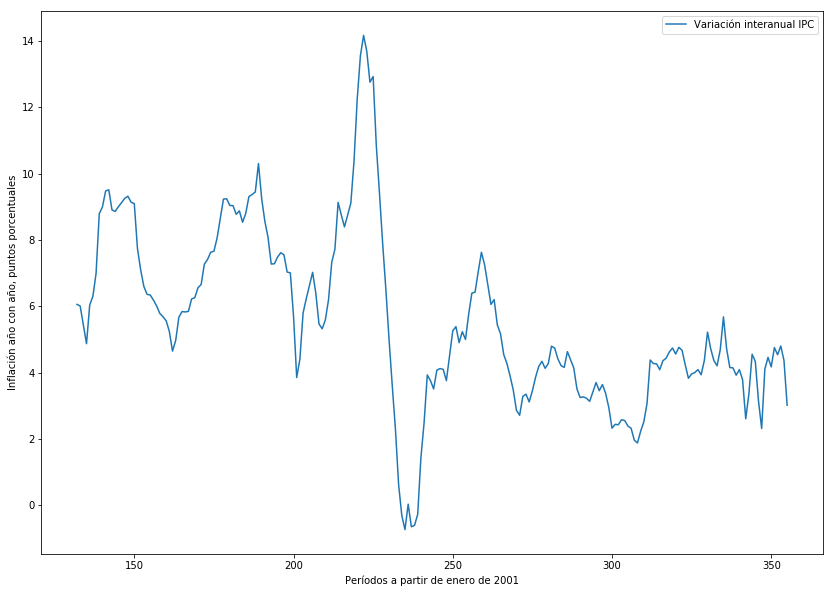

In [19]:
# Graficamos las variaciones interanuales históricas
plt.figure(figsize=(14,10))
plt.plot(data2000["Var.IPC"], label="Variación interanual IPC")
plt.xlabel("Períodos a partir de enero de 2001")
plt.ylabel("Inflación año con año, puntos porcentuales")
plt.legend();

In [20]:
# Semilla 
np.random.seed(7)

In [21]:
# Configuramos el conjunto de datos
dataset = data2000["Var.IPC"].values.astype(np.float32)
dataset = np.reshape(dataset, (-1, 1))
dataset[-6:]

array([[4.171035 ],
       [4.752994 ],
       [4.5369887],
       [4.8      ],
       [4.3696485],
       [3.0129335]], dtype=float32)

## Transformación del conjunto de datos
A continuación, reescalamos el conjunto de datos para un rango manejable por el modelo de RNN. En este caso, de la gráfica anterior, podemos observar que los datos son estacionarios, y por lo tanto, no aplicaremos ninguna transformación para garantizar la estacionariedad de los mismos. Pero este podría ser otro procedimiento necesario (estándar) cuando se trabaja con datos de series de tiempo.

In [24]:
# Normalizar el conjunto de valores entre -1 y 1
scaler = MinMaxScaler(feature_range=(-1, 1))
dataset = scaler.fit_transform(dataset)
dataset[-6:]

array([[-0.3414385 ],
       [-0.26332632],
       [-0.29231915],
       [-0.25701705],
       [-0.31478003],
       [-0.496882  ]], dtype=float32)

In [25]:
# Dividir el conjunto de datos para entrenamiento y prueba
TRAIN_RATIO = 0.8
train_size = int(len(dataset) * TRAIN_RATIO)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print("Observaciones para entrenamiento: %d\nObservaciones para pruebas: %d" % (len(train), len(test)))

Observaciones para entrenamiento: 179
Observaciones para pruebas: 45


## Conversión de los datos a secuencias
En esta parte se hará un tratamiento a los datos para obtener una versión de aprendizaje supervisado, en la cual, las características del modelo serán una cierta cantidad de elementos de la secuencia y el valor a aprender por el modelo será el el siguiente elemento en la secuencia.

In [27]:
# Función para obtener a partir del arreglo dataset un conjunto de datos 
# de entrenamiento y pruebas. El argumento look_back representa la cantidad
# de elementos a utilizar en la secuencia para predecir el siguiente valor.
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [44]:
# Obteniendo los conjuntos de pruebas, X=t and Y=t+1
LOOK_BACK = 6
trainX, trainY = create_dataset(train, LOOK_BACK)
testX, testY = create_dataset(test, LOOK_BACK)

In [45]:
trainX[:10]

array([[-0.08855153, -0.09487815, -0.17239107, -0.24762961, -0.09150393,
        -0.05597527],
       [-0.09487815, -0.17239107, -0.24762961, -0.09150393, -0.05597527,
         0.0368014 ],
       [-0.17239107, -0.24762961, -0.09150393, -0.05597527,  0.0368014 ,
         0.2783747 ],
       [-0.24762961, -0.09150393, -0.05597527,  0.0368014 ,  0.2783747 ,
         0.30574325],
       [-0.09150393, -0.05597527,  0.0368014 ,  0.2783747 ,  0.30574325,
         0.37051883],
       [-0.05597527,  0.0368014 ,  0.2783747 ,  0.30574325,  0.37051883,
         0.375161  ],
       [ 0.0368014 ,  0.2783747 ,  0.30574325,  0.37051883,  0.375161  ,
         0.29358247],
       [ 0.2783747 ,  0.30574325,  0.37051883,  0.375161  ,  0.29358247,
         0.28767458],
       [ 0.30574325,  0.37051883,  0.375161  ,  0.29358247,  0.28767458,
         0.30674353],
       [ 0.37051883,  0.375161  ,  0.29358247,  0.28767458,  0.30674353,
         0.3230342 ]], dtype=float32)

In [46]:
# The LSTM network expects the input data (X) to be provided with a 
# specific array structure in the form of: [samples, time steps, features].

# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [47]:
trainX.shape

(172, 1, 6)

In [49]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(6, input_shape=(1, LOOK_BACK)))
model.add(Dense(1))
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 6)                 312       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 7         
Total params: 319
Trainable params: 319
Non-trainable params: 0
_________________________________________________________________


In [50]:
# Compilar y entrenar el modelo
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=1)

Epoch 1/100
172/172 [==============================] - 1s 8ms/step - loss: 0.0657
Epoch 2/100
172/172 [==============================] - 0s 3ms/step - loss: 0.0426
Epoch 3/100
172/172 [==============================] - 1s 3ms/step - loss: 0.0349
Epoch 4/100
172/172 [==============================] - 1s 3ms/step - loss: 0.0295
Epoch 5/100
172/172 [==============================] - 0s 3ms/step - loss: 0.0244
Epoch 6/100
172/172 [==============================] - 0s 3ms/step - loss: 0.0201
Epoch 7/100
172/172 [==============================] - 0s 3ms/step - loss: 0.0167
Epoch 8/100
172/172 [==============================] - 0s 3ms/step - loss: 0.0143
Epoch 9/100
172/172 [==============================] - 0s 3ms/step - loss: 0.0127
Epoch 10/100
172/172 [==============================] - 0s 3ms/step - loss: 0.0118
Epoch 11/100
172/172 [==============================] - 1s 4ms/step - loss: 0.0110
Epoch 12/100
172/172 [==============================] - 0s 3ms/step - loss: 0.0104
Epoch 13/100


172/172 [==============================] - 0s 3ms/step - loss: 0.0047
Epoch 100/100
172/172 [==============================] - 0s 3ms/step - loss: 0.0047


In [51]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 0.07 RMSE
Test Score: 0.08 RMSE


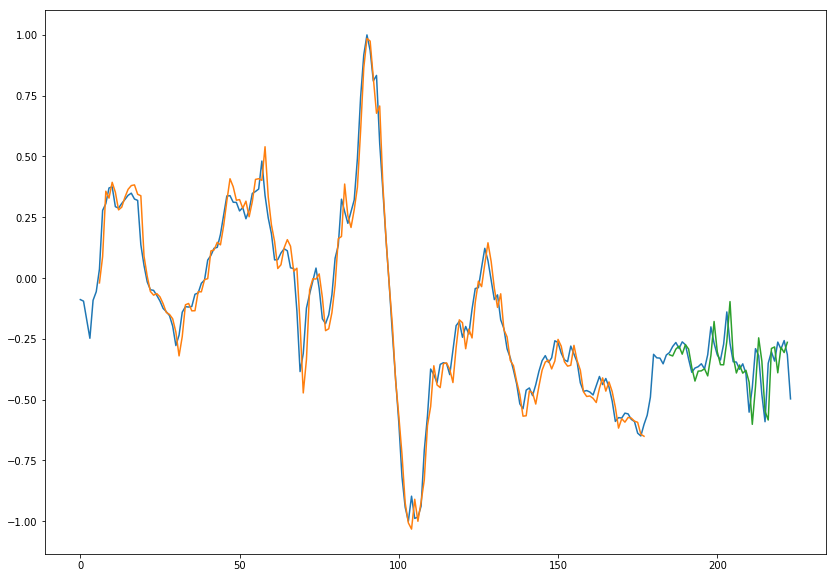

In [52]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[LOOK_BACK:len(trainPredict)+LOOK_BACK, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(LOOK_BACK*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.figure(figsize=(14,10))
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()